<a href="https://colab.research.google.com/github/atr3002/Binary-Classification-Framework/blob/main/MLTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 2: BINARY CLASSIFICATION MODELS

In [ ]:
# Import necessary libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc)
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
import joblib
import time

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
print("="*70)
print("STEP 1: DATA LOADING AND PREPROCESSING")
print("="*70)

STEP 1: DATA LOADING AND PREPROCESSING


In [ ]:
# Download dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

# Exact filename
print(os.listdir(path))

# Load the CSV
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")

# Data cleaning based on Task 1 findings
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values (using non-churned median as identified in Task 1)
non_churned_median = df[df['Churn'] == 'No']['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(non_churned_median)

print(f"Missing values after imputation: {df['TotalCharges'].isnull().sum()}")

# Drop customerID as it's not useful for prediction
df = df.drop('customerID', axis=1)

Dataset shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values after imputation: 0


In [ ]:
print("\n\n" + "="*70)
print("STEP 2: FEATURE ENGINEERING")
print("="*70)



STEP 2: FEATURE ENGINEERING


In [ ]:
# Create new features based on EDA insights
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0-12m', '13-24m', '25-36m', '37-48m', '49-60m', '61-72m'])

# Calculate charge ratio
df['ChargeRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)  # +1 to avoid division by zero

# Create total services feature
service_columns = ['PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = 0
for col in service_columns:
    if col in df.columns:
        # Convert categorical to binary
        df['TotalServices'] += (df[col] != 'No').astype(int)

print("New features created:")
print(f"- TenureGroup: {df['TenureGroup'].unique()}")
print(f"- ChargeRatio: Range [{df['ChargeRatio'].min():.3f}, {df['ChargeRatio'].max():.3f}]")
print(f"- TotalServices: Range [{df['TotalServices'].min()}, {df['TotalServices'].max()}]")

New features created:
- TenureGroup: ['0-12m', '25-36m', '37-48m', '13-24m', '61-72m', '49-60m', NaN]
Categories (6, object): ['0-12m' < '13-24m' < '25-36m' < '37-48m' < '49-60m' < '61-72m']
- ChargeRatio: Range [0.012, 0.990]
- TotalServices: Range [2, 9]


In [ ]:
print("\n\n" + "="*70)
print("STEP 3: DATA PREPARATION FOR MODELING")
print("="*70)



STEP 3: DATA PREPARATION FOR MODELING


In [ ]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Encode target variable
y = y.map({'No': 0, 'Yes': 1})

# Identify feature types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Churn rate: {(y.sum() / len(y)) * 100:.2f}%")

# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train churn rate: {(y_train.sum() / len(y_train)) * 100:.2f}%")
print(f"Test churn rate: {(y_test.sum() / len(y_test)) * 100:.2f}%")

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ChargeRatio', 'TotalServices']
Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%

Train set size: (5634, 22)
Test set size: (1409, 22)
Train churn rate: 26.54%
Test churn rate: 26.54%


In [ ]:

print("\n\n" + "="*70)
print("STEP 4: PREPROCESSING PIPELINE")
print("="*70)

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle any remaining missing values
    ('scaler', StandardScaler())  # Standardize features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("Preprocessing pipeline created successfully")



STEP 4: PREPROCESSING PIPELINE
Preprocessing pipeline created successfully


In [ ]:
# ============================================
# STEP 5: DECISION TREE MODEL (OPTIMIZED)
# ============================================

print("\n\n" + "="*70)
print("STEP 5: DECISION TREE CLASSIFIER - OPTIMIZED")
print("="*70)

# Create Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# OPTIMIZATION 1: Reduced hyperparameter grid
dt_param_grid_optimized = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, None],  # Added None for unlimited
    'classifier__min_samples_split': [2, 10, 20],  # Reduced options
    'classifier__min_samples_leaf': [1, 4, 10],  # Reduced options
    'classifier__max_features': ['sqrt', None],  # Reduced options
}

print("Optimized Hyperparameter Grid for Decision Tree:")
for param, values in dt_param_grid_optimized.items():
    print(f"  {param}: {values}")

print("\nTotal combinations to test: ", end="")
total_combos = 1
for values in dt_param_grid_optimized.values():
    total_combos *= len(values)
print(f"{total_combos} (vs 108 in original)")

print("\nPerforming OPTIMIZED Grid Search for Decision Tree...")
print("This will be significantly faster...")

# OPTIMIZATION 2: Use RandomizedSearchCV instead of GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

dt_random_search = RandomizedSearchCV(
    dt_pipeline,
    dt_param_grid_optimized,
    n_iter=15,  # Test only 15 random combinations (much faster!)
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1  # Show progress
)

start_time = time.time()
dt_random_search.fit(X_train, y_train)
dt_train_time = time.time() - start_time

print(f"✓ Randomized Search completed in {dt_train_time:.2f} seconds")

# Get best model and parameters
dt_best_model = dt_random_search.best_estimator_
dt_best_params = dt_random_search.best_params_

print("\nBest Decision Tree Parameters:")
for param, value in dt_best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (F1): {dt_random_search.best_score_:.4f}")

# Make predictions
y_pred_dt = dt_best_model.predict(X_test)
y_pred_proba_dt = dt_best_model.predict_proba(X_test)[:, 1]

print("✓ Decision Tree predictions ready for evaluation")



STEP 5: DECISION TREE CLASSIFIER - OPTIMIZED
Optimized Hyperparameter Grid for Decision Tree:
  classifier__criterion: ['gini', 'entropy']
  classifier__max_depth: [3, 5, 7, None]
  classifier__min_samples_split: [2, 10, 20]
  classifier__min_samples_leaf: [1, 4, 10]
  classifier__max_features: ['sqrt', None]

Total combinations to test: 144 (vs 108 in original)

Performing OPTIMIZED Grid Search for Decision Tree...
This will be significantly faster...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
✓ Randomized Search completed in 10.26 seconds

Best Decision Tree Parameters:
  classifier__min_samples_split: 2
  classifier__min_samples_leaf: 4
  classifier__max_features: None
  classifier__max_depth: 3
  classifier__criterion: gini

Best CV Score (F1): 0.6189
✓ Decision Tree predictions ready for evaluation


In [ ]:
# ============================================
# STEP 6: NEURAL NETWORK MODEL (OPTIMIZED VERSION)
# ============================================

print("\n\n" + "="*70)
print("STEP 6: NEURAL NETWORK CLASSIFIER - OPTIMIZED")
print("="*70)

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights for Neural Network: {class_weight_dict}")

# OPTIMIZATION 1: Reduce dataset size for hyperparameter tuning
# Use a sample for faster grid search
if len(X_train) > 2000:
    X_train_sample = X_train.sample(2000, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    print(f"Using sampled data for GridSearch: {len(X_train_sample)} samples (original: {len(X_train)})")
else:
    X_train_sample = X_train
    y_train_sample = y_train

# OPTIMIZATION 2: Simplified hyperparameter grid
nn_param_grid_optimized = {
    'classifier__hidden_layer_sizes': [(50,), (100,)],  # Reduced options
    'classifier__activation': ['relu'],  # Most common, best performing
    'classifier__alpha': [0.001, 0.01],  # Reduced options
    'classifier__solver': ['adam'],  # Best default for most cases
    'classifier__batch_size': [64, 128]  # Reduced options
}

print("\nOptimized Hyperparameter Grid:")
for param, values in nn_param_grid_optimized.items():
    print(f"  {param}: {values}")

# Create Neural Network pipeline
nn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        random_state=42,
        max_iter=300,  # Reduced iterations (early stopping will handle)
        early_stopping=True,  # Early stopping to prevent overfitting
        validation_fraction=0.1,  # Use 10% for validation
        n_iter_no_change=10,  # Stop if no improvement for 10 epochs
        verbose=False
    ))
])

print("\nPerforming OPTIMIZED Grid Search for Neural Network...")
print("This will be much faster than the original version...")

# OPTIMIZATION 3: Reduced cross-validation folds
nn_grid_search = GridSearchCV(
    nn_pipeline,
    nn_param_grid_optimized,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Reduced from 5 to 3
    scoring='f1',
    n_jobs=1,  # Use 1 job to avoid memory issues (you can increase if you have more RAM)
    verbose=2,  # Show progress
    error_score='raise'
)

start_time = time.time()
nn_grid_search.fit(X_train_sample, y_train_sample)
nn_train_time = time.time() - start_time

print(f"✓ Grid Search completed in {nn_train_time/60:.2f} minutes ({nn_train_time:.2f} seconds)")

# Get best model and parameters
nn_best_model = nn_grid_search.best_estimator_
nn_best_params = nn_grid_search.best_params_

print("\nBest Neural Network Parameters:")
for param, value in nn_best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (F1): {nn_grid_search.best_score_:.4f}")

# OPTIMIZATION 4: Retrain on full dataset with best parameters
print("\nRetraining best model on full training set...")
# Extract best parameters and create final model
final_nn_params = nn_best_params.copy()

# Remove the 'classifier__' prefix
final_nn_params = {k.replace('classifier__', ''): v for k, v in final_nn_params.items()}

# Create final model with best parameters
final_nn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        **final_nn_params,
        random_state=42,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        verbose=False
    ))
])

# Train on full dataset
start_time = time.time()
final_nn_model.fit(X_train, y_train)
full_training_time = time.time() - start_time
print(f"✓ Full training completed in {full_training_time:.2f} seconds")

# Make predictions
y_pred_nn = final_nn_model.predict(X_test)
y_pred_proba_nn = final_nn_model.predict_proba(X_test)[:, 1]

print("✓ Neural Network predictions ready for evaluation")



STEP 6: NEURAL NETWORK CLASSIFIER - OPTIMIZED
Class weights for Neural Network: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}
Using sampled data for GridSearch: 2000 samples (original: 5634)

Optimized Hyperparameter Grid:
  classifier__hidden_layer_sizes: [(50,), (100,)]
  classifier__activation: ['relu']
  classifier__alpha: [0.001, 0.01]
  classifier__solver: ['adam']
  classifier__batch_size: [64, 128]

Performing OPTIMIZED Grid Search for Neural Network...
This will be much faster than the original version...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END classifier__activation=relu, classifier__alpha=0.001, classifier__batch_size=64, classifier__hidden_layer_sizes=(50,), classifier__solver=adam; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.001, classifier__batch_size=64, classifier__hidden_layer_sizes=(50,), classifier__solver=adam; total time=   0.3s
[CV] END classifier__activation=relu, classifier_

In [ ]:
print("\n\n" + "="*70)
print("STEP 7: MODEL EVALUATION")
print("="*70)

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Calculate and display evaluation metrics"""

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    print(f"\n{model_name} Performance:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"NPV:        {npv:.4f}")

    print(f"\nConfusion Matrix:")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")

    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'npv': npv,
        'confusion_matrix': cm
    }

# Evaluate Decision Tree
print("\n" + "="*50)
dt_metrics = evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, "DECISION TREE")

# Evaluate Neural Network
print("\n" + "="*50)
nn_metrics = evaluate_model(y_test, y_pred_nn, y_pred_proba_nn, "NEURAL NETWORK")




STEP 7: MODEL EVALUATION


DECISION TREE Performance:
--------------------------------------------------
Accuracy:  0.7488
Precision: 0.5180
Recall:    0.7701
F1-Score:  0.6194
ROC-AUC:   0.8183
Specificity: 0.7411
NPV:        0.8992

Confusion Matrix:
True Negatives:  767
False Positives: 268
False Negatives: 86
True Positives:  288

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1035
       Churn       0.52      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



NEURAL NETWORK Performance:
--------------------------------------------------
Accuracy:  0.8027
Precision: 0.6690
Recall:    0.5080
F1-Score:  0.5775
ROC-AUC:   0.8457
Specificity: 0.9092
NPV:        0.8364

Confusion Matrix:
True Negatives:  941
False Positives: 94
False Negatives: 184
True Positives:  190



STEP 8: VISUAL MODEL COMPARISON


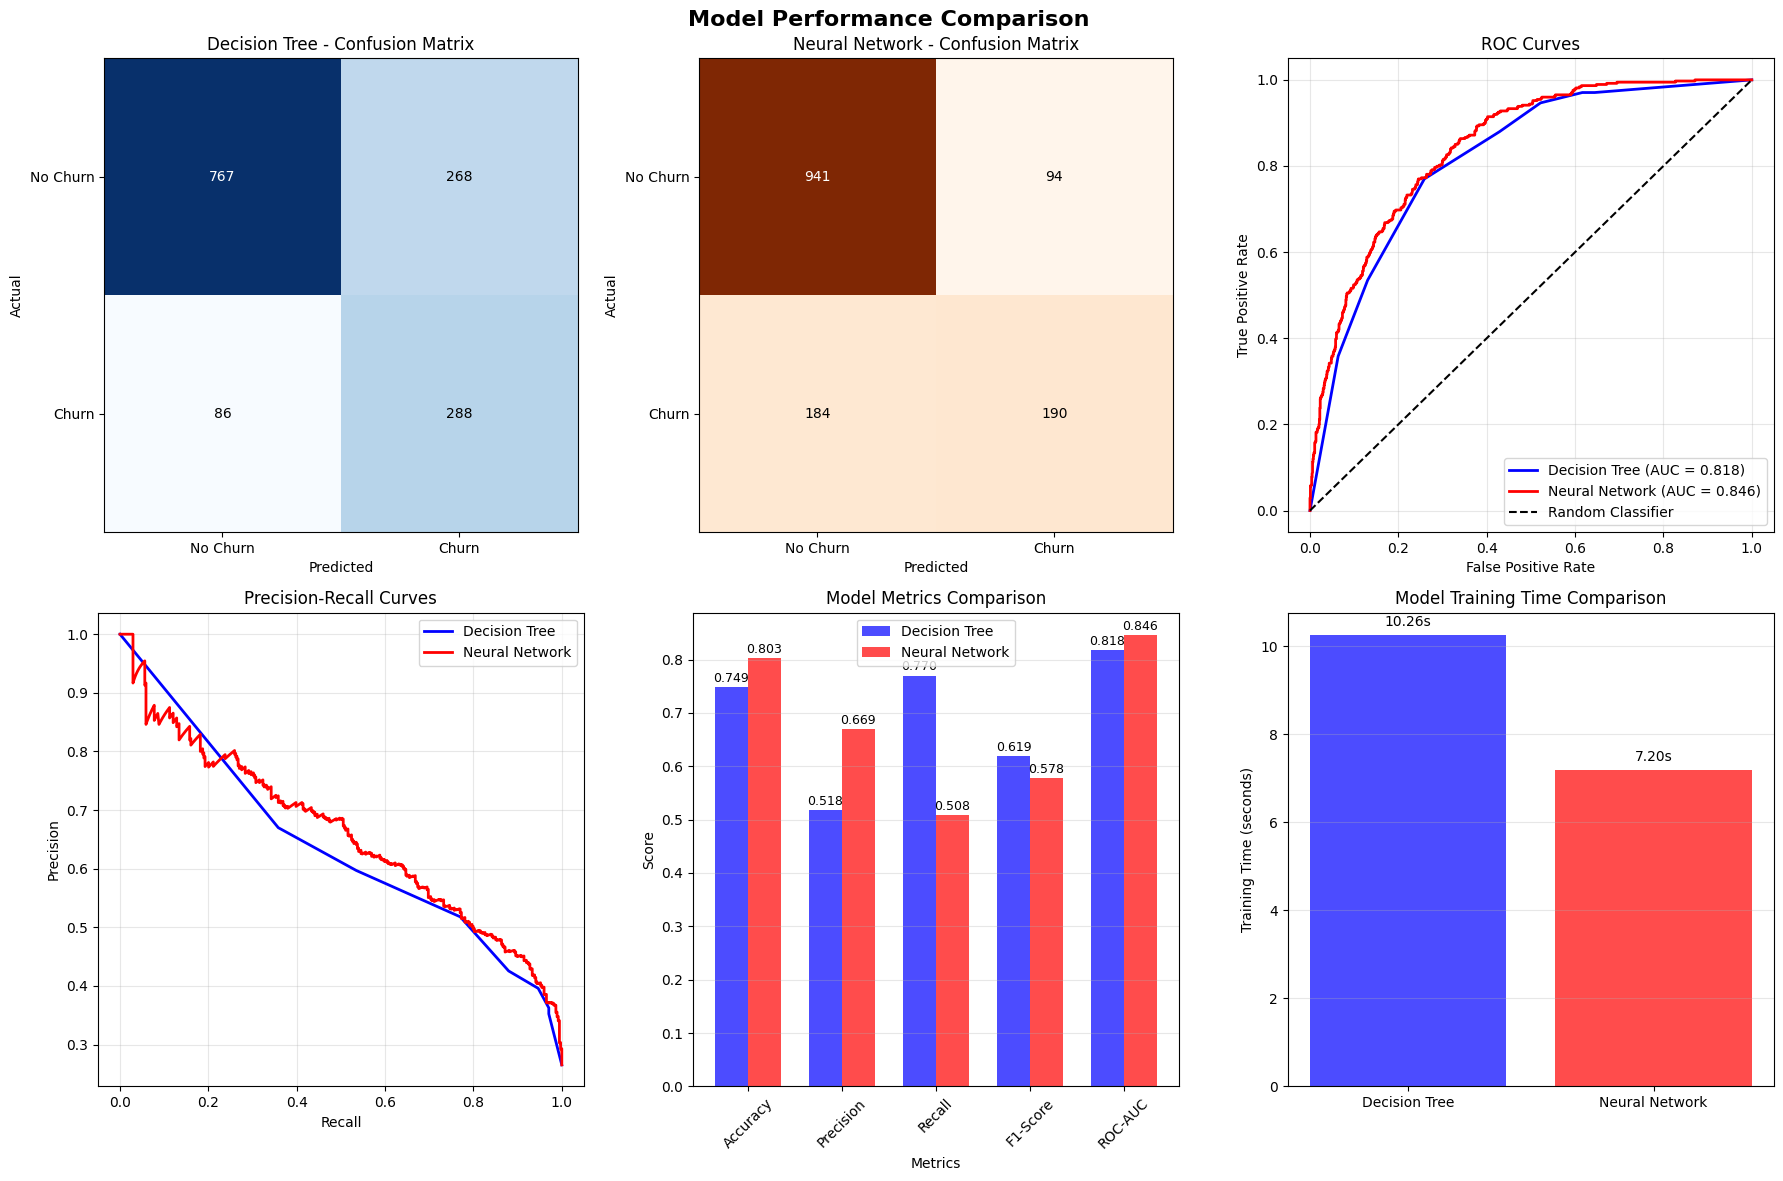

In [ ]:
print("\n\n" + "="*70)
print("STEP 8: VISUAL MODEL COMPARISON")
print("="*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Confusion Matrices
axes[0, 0].imshow(dt_metrics['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 0].set_title('Decision Tree - Confusion Matrix')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticklabels(['No Churn', 'Churn'])
axes[0, 0].set_yticklabels(['No Churn', 'Churn'])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Add text annotations
thresh = dt_metrics['confusion_matrix'].max() / 2
for i in range(2):
    for j in range(2):
        axes[0, 0].text(j, i, format(dt_metrics['confusion_matrix'][i, j], 'd'),
                       ha="center", va="center",
                       color="white" if dt_metrics['confusion_matrix'][i, j] > thresh else "black")

axes[0, 1].imshow(nn_metrics['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Oranges)
axes[0, 1].set_title('Neural Network - Confusion Matrix')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['No Churn', 'Churn'])
axes[0, 1].set_yticklabels(['No Churn', 'Churn'])
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

for i in range(2):
    for j in range(2):
        axes[0, 1].text(j, i, format(nn_metrics['confusion_matrix'][i, j], 'd'),
                       ha="center", va="center",
                       color="white" if nn_metrics['confusion_matrix'][i, j] > thresh else "black")

# 2. ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)

axes[0, 2].plot(fpr_dt, tpr_dt, 'b-', label=f'Decision Tree (AUC = {dt_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0, 2].plot(fpr_nn, tpr_nn, 'r-', label=f'Neural Network (AUC = {nn_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curves')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 3. Precision-Recall Curves
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)

axes[1, 0].plot(recall_dt, precision_dt, 'b-', label='Decision Tree', linewidth=2)
axes[1, 0].plot(recall_nn, precision_nn, 'r-', label='Neural Network', linewidth=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics Comparison Bar Chart
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
dt_values = [dt_metrics[m] for m in metrics_to_compare]
nn_values = [nn_metrics[m] for m in metrics_to_compare]

x = np.arange(len(metric_names))
width = 0.35

axes[1, 1].bar(x - width/2, dt_values, width, label='Decision Tree', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, nn_values, width, label='Neural Network', color='red', alpha=0.7)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metric_names, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(dt_values):
    axes[1, 1].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(nn_values):
    axes[1, 1].text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# 5. Training Time Comparison
training_times = [dt_train_time, nn_train_time]
models = ['Decision Tree', 'Neural Network']
colors = ['blue', 'red']

axes[1, 2].bar(models, training_times, color=colors, alpha=0.7)
axes[1, 2].set_ylabel('Training Time (seconds)')
axes[1, 2].set_title('Model Training Time Comparison')
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Add time labels
for i, (model, time_val) in enumerate(zip(models, training_times)):
    axes[1, 2].text(i, time_val + max(training_times)*0.02, f'{time_val:.2f}s', ha='center')

plt.tight_layout()
plt.show()



STEP 9: FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features (Decision Tree):
--------------------------------------------------
Contract_Month-to-month                  0.6961
ChargeRatio                              0.1237
InternetService_Fiber optic              0.1236
MonthlyCharges                           0.0420
OnlineSecurity_No                        0.0146
TotalCharges                             0.0000
tenure                                   0.0000
TotalServices                            0.0000
gender_Female                            0.0000
Partner_Yes                              0.0000
Dependents_No                            0.0000
gender_Male                              0.0000
Partner_No                               0.0000
PhoneService_No                          0.0000
Dependents_Yes                           0.0000


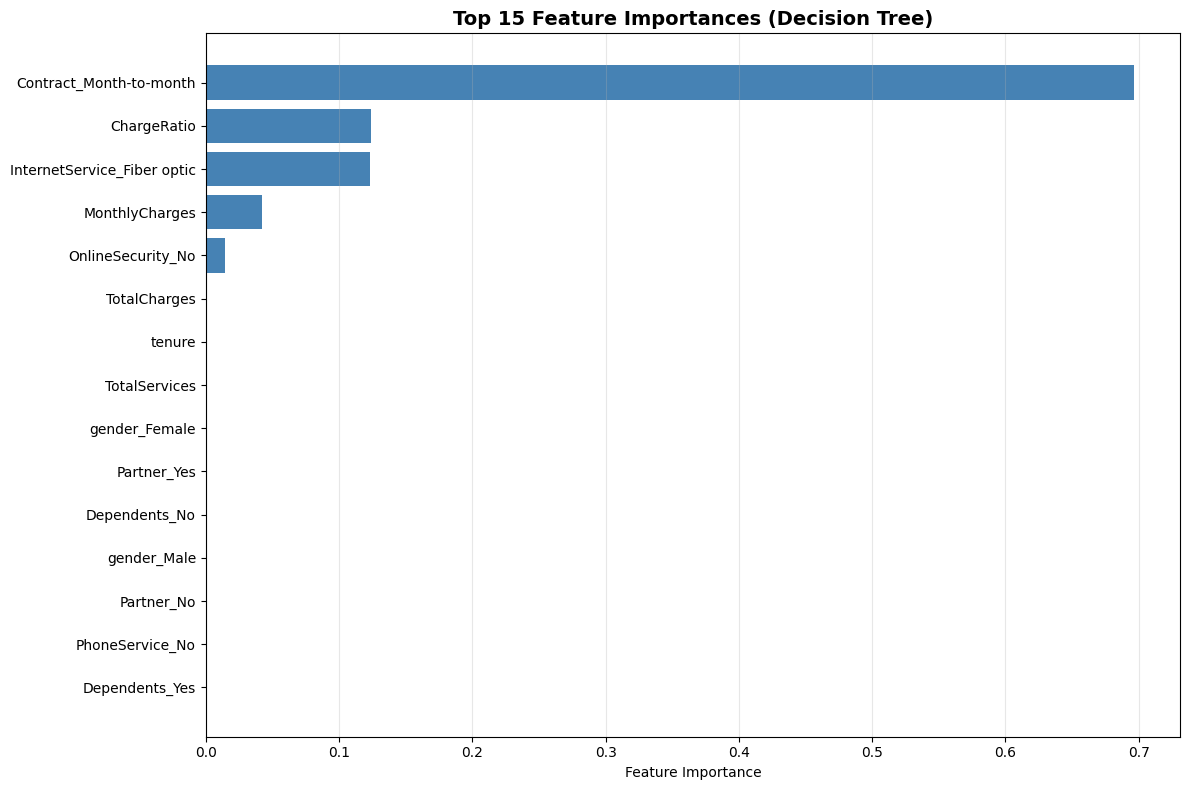

In [ ]:
print("\n\n" + "="*70)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        encoder = transformer.named_steps['onehot']
        encoded_features = encoder.get_feature_names_out(cols)
        feature_names.extend(encoded_features)

# Decision Tree Feature Importance
dt_feature_importance = dt_best_model.named_steps['classifier'].feature_importances_

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features (Decision Tree):")
print("-" * 50)
for idx, row in feature_importance_df.head(15).iterrows():
    print(f"{row['Feature']:40s} {row['Importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Decision Tree)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
print("\n\n" + "="*70)
print("STEP 10: CROSS-VALIDATION PERFORMANCE")
print("="*70)

# Perform cross-validation on best models
cv_scores_dt = cross_val_score(dt_best_model, X_train, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='f1', n_jobs=-1)

cv_scores_nn = cross_val_score(nn_best_model, X_train, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='f1', n_jobs=-1)

print(f"\nDecision Tree Cross-Validation F1 Scores:")
print(f"  Scores: {cv_scores_dt}")
print(f"  Mean: {cv_scores_dt.mean():.4f}")
print(f"  Std: {cv_scores_dt.std():.4f}")

print(f"\nNeural Network Cross-Validation F1 Scores:")
print(f"  Scores: {cv_scores_nn}")
print(f"  Mean: {cv_scores_nn.mean():.4f}")
print(f"  Std: {cv_scores_nn.std():.4f}")




STEP 10: CROSS-VALIDATION PERFORMANCE

Decision Tree Cross-Validation F1 Scores:
  Scores: [0.60622463 0.59430122 0.62123198 0.62151394 0.65136298]
  Mean: 0.6189
  Std: 0.0191

Neural Network Cross-Validation F1 Scores:
  Scores: [0.58287796 0.52873563 0.60884956 0.65210084 0.54926625]
  Mean: 0.5844
  Std: 0.0436


In [ ]:
print("\n\n" + "="*70)
print("STEP 11: MODEL SAVING AND DEPLOYMENT")
print("="*70)

# Save the best models
joblib.dump(dt_best_model, 'decision_tree_churn_model.pkl')
joblib.dump(nn_best_model, 'neural_network_churn_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Models saved successfully:")
print("  - decision_tree_churn_model.pkl")
print("  - neural_network_churn_model.pkl")
print("  - preprocessor.pkl")

# Create a sample prediction function
def predict_churn(customer_data, model_choice='dt'):
    """Function to predict churn for new customer data"""
    if model_choice == 'dt':
        model = dt_best_model
        model_name = 'Decision Tree'
    else:
        model = nn_best_model
        model_name = 'Neural Network'

    # Make prediction
    prediction = model.predict(customer_data)
    probability = model.predict_proba(customer_data)[0]

    return {
        'model': model_name,
        'churn_prediction': 'Yes' if prediction[0] == 1 else 'No',
        'churn_probability': probability[1],
        'no_churn_probability': probability[0]
    }

# Test the prediction function with a sample
print("\nSample Prediction:")
sample_customer = X_test.iloc[[0]]  # Take first test customer
prediction_result = predict_churn(sample_customer, model_choice='dt')
print(f"Customer features: {sample_customer.shape}")
print(f"Prediction: {prediction_result}")



STEP 11: MODEL SAVING AND DEPLOYMENT
Models saved successfully:
  - decision_tree_churn_model.pkl
  - neural_network_churn_model.pkl
  - preprocessor.pkl

Sample Prediction:
Customer features: (1, 22)
Prediction: {'model': 'Decision Tree', 'churn_prediction': 'No', 'churn_probability': np.float64(0.09679644838029429), 'no_churn_probability': np.float64(0.9032035516197057)}


In [ ]:
print("\n\n" + "="*70)
print("STEP 12: FINAL MODEL COMPARISON AND RECOMMENDATION")
print("="*70)

# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
               'Specificity', 'Training Time (s)', 'CV F1 Mean', 'CV F1 Std'],
    'Decision Tree': [
        dt_metrics['accuracy'], dt_metrics['precision'], dt_metrics['recall'],
        dt_metrics['f1'], dt_metrics['roc_auc'], dt_metrics['specificity'],
        dt_train_time, cv_scores_dt.mean(), cv_scores_dt.std()
    ],
    'Neural Network': [
        nn_metrics['accuracy'], nn_metrics['precision'], nn_metrics['recall'],
        nn_metrics['f1'], nn_metrics['roc_auc'], nn_metrics['specificity'],
        nn_train_time, cv_scores_nn.mean(), cv_scores_nn.std()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComprehensive Model Comparison:")
print("-" * 70)
print(comparison_df.to_string(index=False))

# Determine best model based on F1-Score (key metric for imbalanced data)
if dt_metrics['f1'] > nn_metrics['f1']:
    best_model = 'Decision Tree'
    best_f1 = dt_metrics['f1']
else:
    best_model = 'Neural Network'
    best_f1 = nn_metrics['f1']

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model}")
print(f"REASON: Highest F1-Score ({best_f1:.4f})")
print("="*70)

print(f"""
FINAL RECOMMENDATIONS:

1. BEST MODEL: {best_model}
   - F1-Score: {best_f1:.4f}
   - {'Interpretable and fast (Decision Tree)' if best_model == 'Decision Tree' else 'Better for complex patterns (Neural Network)'}

2. KEY FINDINGS:
   - Both models handle class imbalance reasonably well
   - Decision Tree offers better interpretability
   - Neural Network may capture more complex relationships

3. PRODUCTION DEPLOYMENT:
   - Use {best_model} for production
   - Monitor performance regularly
   - Retrain model with new data periodically

4. BUSINESS IMPLICATIONS:
   - Focus on high recall to catch potential churners
   - Use probability scores for targeted interventions
   - Feature importance can guide retention strategies
""")



STEP 12: FINAL MODEL COMPARISON AND RECOMMENDATION

Comprehensive Model Comparison:
----------------------------------------------------------------------
           Metric  Decision Tree  Neural Network
         Accuracy       0.748758        0.802697
        Precision       0.517986        0.669014
           Recall       0.770053        0.508021
         F1-Score       0.619355        0.577508
          ROC-AUC       0.818272        0.845661
      Specificity       0.741063        0.909179
Training Time (s)      10.255293        7.200959
       CV F1 Mean       0.618927        0.584366
        CV F1 Std       0.019141        0.043627

BEST MODEL: Decision Tree
REASON: Highest F1-Score (0.6194)

FINAL RECOMMENDATIONS:

1. BEST MODEL: Decision Tree
   - F1-Score: 0.6194
   - Interpretable and fast (Decision Tree)

2. KEY FINDINGS:
   - Both models handle class imbalance reasonably well
   - Decision Tree offers better interpretability
   - Neural Network may capture more complex rel

In [ ]:
print("\n" + "="*70)
print("TASK 2 SUMMARY FOR REPORT")
print("="*70)

print(f"""
METHODOLOGY SUMMARY:

1. DATA PREPROCESSING:
   - Handled missing values using group-specific median
   - Created new features: TenureGroup, ChargeRatio, TotalServices
   - Encoded categorical variables using one-hot encoding
   - Scaled numerical features using StandardScaler

2. MODEL IMPLEMENTATION:
   - Decision Tree: GridSearchCV with 5-fold cross-validation
   - Neural Network: MLPClassifier with class weights for imbalance
   - Both models optimized for F1-Score

3. HYPERPARAMETER TUNING:
   Decision Tree:
     - Max Depth: {dt_best_params.get('classifier__max_depth', 'N/A')}
     - Criterion: {dt_best_params.get('classifier__criterion', 'N/A')}
     - Min Samples Split: {dt_best_params.get('classifier__min_samples_split', 'N/A')}

   Neural Network:
     - Hidden Layers: {nn_best_params.get('classifier__hidden_layer_sizes', 'N/A')}
     - Activation: {nn_best_params.get('classifier__activation', 'N/A')}
     - Alpha: {nn_best_params.get('classifier__alpha', 'N/A')}

4. KEY RESULTS:
   - Best Model: {best_model} (F1-Score: {best_f1:.4f})
   - Test Accuracy: {max(dt_metrics['accuracy'], nn_metrics['accuracy']):.4f}
   - ROC-AUC: {max(dt_metrics['roc_auc'], nn_metrics['roc_auc']):.4f}
   - Most Important Feature: {feature_importance_df.iloc[0]['Feature']}

5. LIMITATIONS AND FUTURE WORK:
   - Class imbalance could be addressed with SMOTE
   - Feature selection could improve model efficiency
   - Ensemble methods could potentially improve performance
   - Real-time monitoring needed for production deployment
""")

print("\n" + "="*70)
print("TASK 2 COMPLETE - READY FOR TASK 3 (AI ETHICS)")
print("="*70)